In [33]:
import numpy as np  # to handle matrix
import pandas as pd # to handle data
from matplotlib import pyplot as plt # to visualize
import datetime, pytz # to handle time
from sklearn.model_selection import train_test_split # Split data
from sklearn.ensemble import RandomForestRegressor # Random Forest Classifier

In [34]:
# Define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

In [35]:
df = pd.read_csv('BTC-USD (2014-2024)_2.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Volume USD
0,9/18/2014,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,14636049477
1,9/19/2014,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,14970545502
2,9/20/2014,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,15073673199
3,9/21/2014,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,10600702434
4,9/22/2014,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0,9702962788


In [36]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

In [37]:
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill "NaN"s with zeroes for relevant fields...
df['Volume'].fillna(value=0, inplace=True)
df['Volume USD'].fillna(value=0, inplace=True)
df['Adj Close'].fillna(value=0, inplace=True)

# Secondly, we need to fix the OHLC (open, high, low, close) data which is a continuous timeseries so
# let's fill forwards those values.
df['Open'].fillna(method='ffill', inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Low'].fillna(method='ffill', inplace=True)
df['Close'].fillna(method='ffill', inplace=True)

df.tail()

C:\Users\maggi\AppData\Local\Temp\ipykernel_1980\2998783644.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Volume'].fillna(value=0, inplace=True)
C:\Users\maggi\AppData\Local\Temp\ipykernel_1980\2998783644.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

,Date,Open,High,Low,Close,Adj Close,Volume,Volume USD
3408,2024-01-17,43132.10156,43189.89063,42189.30859,42742.65234,42742.65234,2.085123e+10,8.91237E+14
3409,2024-01-18,42742.31250,42876.34766,40631.17188,41262.05859,41262.05859,2.521836e+10,1.04056E+15
3410,2024-01-19,41278.46094,42134.16016,40297.45703,41618.40625,41618.40625,2.575241e+10,1.07177E+15
3411,2024-01-20,41278.46094,42134.16016,40297.45703,41618.40625,0.00000,0.000000e+00,#VALUE!
3412,2024-01-21,41671.48828,41693.16016,41615.14063,41623.69531,41623.69531,1.127404e+10,4.69267E+14


In [39]:
start = df['Date'].min()
end = '2024-01-19'

# find rows between start and end time and find the first row (00:00 monday morning)
# Grouping by day
daily_df = df[(df['Date'] >= start) & (df['Date'] <= end)].groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
daily_df = daily_df.set_index('Date')
daily_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,Volume USD
Date,,,,,,,
2024-01-17,43132.10156,43189.89063,42189.30859,42742.65234,42742.65234,2.085123e+10,8.91237E+14
2024-01-18,42742.31250,42876.34766,40631.17188,41262.05859,41262.05859,2.521836e+10,1.04056E+15
2024-01-19,41278.46094,42134.16016,40297.45703,41618.40625,41618.40625,2.575241e+10,1.07177E+15


In [40]:
# Again fill NaN
daily_df['Volume'].fillna(value=0, inplace=True)
daily_df['Volume USD'].fillna(value=0, inplace=True)
daily_df['Adj Close'].fillna(value=0, inplace=True)

daily_df['Open'].fillna(method='ffill', inplace=True)
daily_df['High'].fillna(method='ffill', inplace=True)
daily_df['Low'].fillna(method='ffill', inplace=True)
daily_df['Close'].fillna(method='ffill', inplace=True)

print("Shape: ", daily_df.shape)
print("Columns= ", daily_df.columns)
print("Is There any 'NaN' value: ", daily_df.isnull().values.any())
print("Is there any duplicate value: ", daily_df.index.duplicated().any())
daily_df.tail(3)

Shape:  (3411, 7)
Columns=  Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Volume USD'], dtype='object')
Is There any 'NaN' value:  False
Is there any duplicate value:  False


C:\Users\maggi\AppData\Local\Temp\ipykernel_1980\3516788080.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_df['Volume'].fillna(value=0, inplace=True)
C:\Users\maggi\AppData\Local\Temp\ipykernel_1980\3516788080.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

,Open,High,Low,Close,Adj Close,Volume,Volume USD
Date,,,,,,,
2024-01-17,43132.10156,43189.89063,42189.30859,42742.65234,42742.65234,2.085123e+10,8.91237E+14
2024-01-18,42742.31250,42876.34766,40631.17188,41262.05859,41262.05859,2.521836e+10,1.04056E+15
2024-01-19,41278.46094,42134.16016,40297.45703,41618.40625,41618.40625,2.575241e+10,1.07177E+15


In [41]:
historical_df = daily_df
for i in range(1,8): # for 7 days
    historical_df["Open_b_"+str(i)] = daily_df['Open'].shift(i)
    historical_df["High_b_"+str(i)] = daily_df['High'].shift(i)
    historical_df["Low_b_"+str(i)]  = daily_df['Low'].shift(i)
    historical_df["Close_b_"+str(i)]= daily_df['Close'].shift(i)
    historical_df["Volume_b_"+str(i)]      = daily_df['Volume'].shift(i)
    historical_df["Volume_USD_b_"+str(i)] = daily_df['Volume USD'].shift(i)

historical_df = historical_df.dropna() # drop the first rows. They don't have previous information 
print("Historical Data Shape: ", historical_df.shape)
historical_df.tail(3)

Historical Data Shape:  (3404, 49)


,Open,High,Low,Close,Adj Close,Volume,Volume USD,Open_b_1,High_b_1,Low_b_1,...,Low_b_6,Close_b_6,Volume_b_6,Volume_USD_b_6,Open_b_7,High_b_7,Low_b_7,Close_b_7,Volume_b_7,Volume_USD_b_7
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,43132.10156,43189.89063,42189.30859,42742.65234,42742.65234,2.085123e+10,8.91237E+14,42499.33594,43566.27344,42085.99609,...,45678.64453,46368.58594,4.583373e+10,2.12525E+15,46121.53906,47647.22266,44483.15234,46627.77734,5.011461e+10,2.33673E+15
2024-01-18,42742.31250,42876.34766,40631.17188,41262.05859,41262.05859,2.521836e+10,1.04056E+15,43132.10156,43189.89063,42189.30859,...,41903.76953,42853.16797,4.333270e+10,1.85694E+15,46656.07422,48969.37109,45678.64453,46368.58594,4.583373e+10,2.12525E+15
2024-01-19,41278.46094,42134.16016,40297.45703,41618.40625,41618.40625,2.575241e+10,1.07177E+15,42742.31250,42876.34766,40631.17188,...,42464.14453,42842.38281,2.060186e+10,8.82633E+14,46354.79297,46498.13672,41903.76953,42853.16797,4.333270e+10,1.85694E+15


In [42]:
historical_df["NEXT_CLOSE"] = historical_df['Close'].shift(-1) # Add next data as a label for current data
historical_df = historical_df.dropna() # drop the last row. It doesn't have next information 
print("after adding next CLOSE Label, new shape:", historical_df.shape)
historical_df.tail(3)

after adding next CLOSE Label, new shape: (3403, 50)


C:\Users\maggi\AppData\Local\Temp\ipykernel_1980\2295155591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_df["NEXT_CLOSE"] = historical_df['Close'].shift(-1) # Add next data as a label for current data


,Open,High,Low,Close,Adj Close,Volume,Volume USD,Open_b_1,High_b_1,Low_b_1,...,Close_b_6,Volume_b_6,Volume_USD_b_6,Open_b_7,High_b_7,Low_b_7,Close_b_7,Volume_b_7,Volume_USD_b_7,NEXT_CLOSE
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-16,42499.33594,43566.27344,42085.99609,43154.94531,43154.94531,2.406287e+10,1.03843E+15,41715.06641,43319.72266,41705.41797,...,46627.77734,5.011461e+10,2.33673E+15,46987.64063,47893.69922,45244.71484,46139.73047,3.982129e+10,1.83734E+15,42742.65234
2024-01-17,43132.10156,43189.89063,42189.30859,42742.65234,42742.65234,2.085123e+10,8.91237E+14,42499.33594,43566.27344,42085.99609,...,46368.58594,4.583373e+10,2.12525E+15,46121.53906,47647.22266,44483.15234,46627.77734,5.011461e+10,2.33673E+15,41262.05859
2024-01-18,42742.31250,42876.34766,40631.17188,41262.05859,41262.05859,2.521836e+10,1.04056E+15,43132.10156,43189.89063,42189.30859,...,42853.16797,4.333270e+10,1.85694E+15,46656.07422,48969.37109,45678.64453,46368.58594,4.583373e+10,2.12525E+15,41618.40625


In [43]:
# split data
prediction_days = 140
df_train = historical_df[:len(historical_df) - prediction_days ]
df_test  = historical_df[ len(historical_df) - prediction_days:]

print("PERCENT test/total data = %", (prediction_days/len(historical_df)) * 100)
print("train data shape:", df_train.shape)
print("test data shape:", df_test.shape)

training_set = df_train.values
X_train = training_set[0:len(training_set), 0:49]
y_train = training_set[0:len(training_set), 49].reshape(-1,1)

test_set = df_test.values
X_test = test_set[0:len(test_set), 0:49]
y_test = test_set[0:len(test_set), 49].reshape(-1,1)

df_train.head(3)

PERCENT test/total data = % 4.114017043784895
train data shape: (3263, 50)
test data shape: (140, 50)


,Open,High,Low,Close,Adj Close,Volume,Volume USD,Open_b_1,High_b_1,Low_b_1,...,Close_b_6,Volume_b_6,Volume_USD_b_6,Open_b_7,High_b_7,Low_b_7,Close_b_7,Volume_b_7,Volume_USD_b_7,NEXT_CLOSE
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-25,423.156006,423.519989,409.467987,411.574005,411.574005,26814400.0,11036110000,435.751007,436.112000,421.131989,...,394.795990,37919700.0,14970545502,456.859985,456.859985,413.104004,424.440002,34483200.0,14636049477,404.424988
2014-09-26,411.428986,414.937988,400.009003,404.424988,404.424988,21460800.0,8679283782,423.156006,423.519989,409.467987,...,408.903992,36863600.0,15073673199,424.102997,427.834991,384.532013,394.795990,37919700.0,14970545502,399.519989
2014-09-27,403.556000,406.622986,397.372009,399.519989,399.519989,15029300.0,6004505771,411.428986,414.937988,400.009003,...,398.821014,26580100.0,10600702434,394.673004,423.295990,389.882996,408.903992,36863600.0,15073673199,377.181000


In [44]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)
rf.fit(X_train, np.ravel(y_train));
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = np.sqrt(np.mean(np.square(predictions.reshape(-1,1) - y_test.reshape(-1,1) )))
# Print out the root mean square error (rmse)
print('RMSE:', errors)
print('R^2 Score - Coefficient of Determination', rf.score(X_test, y_test))

RMSE: 1080.2366087699645
R^2 Score - Coefficient of Determination 0.975868681448704


In [45]:
df_Result = pd.DataFrame(y_test, index=df_test.index, columns=["NEXT_CLOSE"])
df_Result['Predicted'] = predictions
df_Result = df_Result.sort_values('Date')
df_Result.tail(3)

,NEXT_CLOSE,Predicted
Date,,
2024-01-16,42742.65234,43073.284231
2024-01-17,41262.05859,42404.409720
2024-01-18,41618.40625,41092.525669


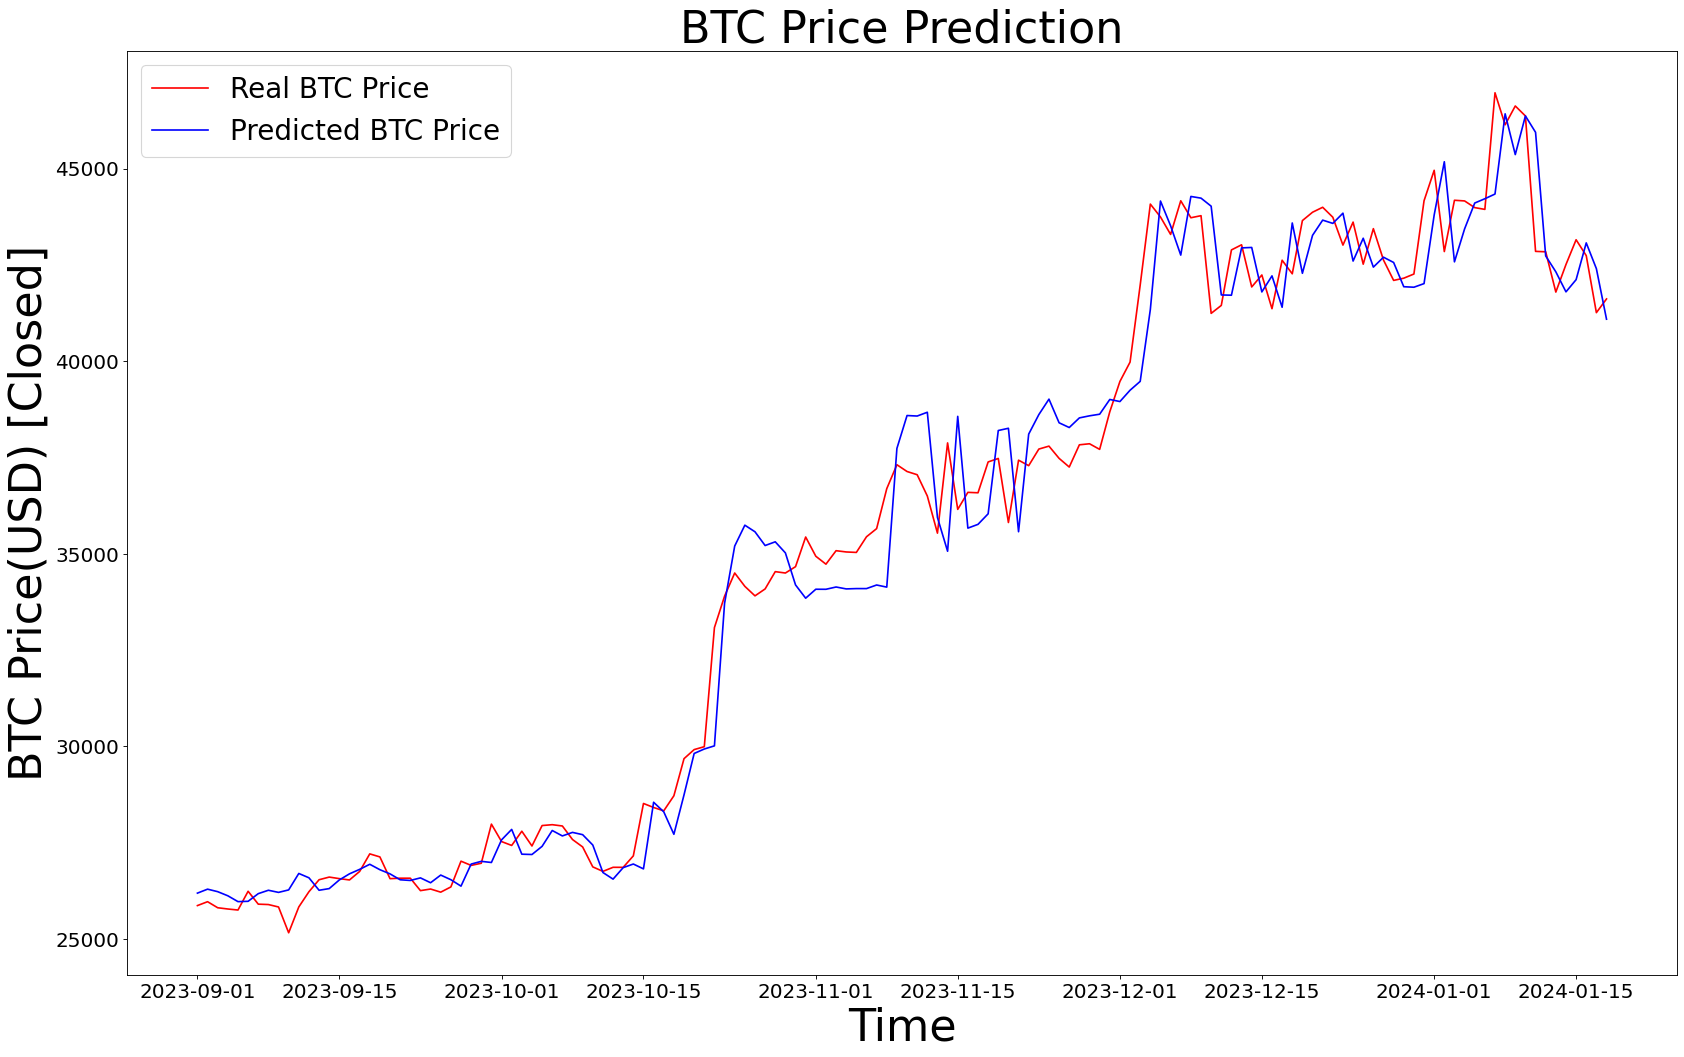

In [46]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(df_Result['NEXT_CLOSE'], color = 'red', label = 'Real BTC Price')
plt.plot(df_Result['Predicted'], color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_Result.reset_index()
x = df_test.index
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD) [Closed]', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()